In [1]:
# import modules
import numpy as np
from sklearn.datasets import load_digits
from abc import abstractmethod

# Base Classes

In [2]:
class Node:
    '''
      this class will later get the following attributes
      all nodes:
          features
          responses
      split nodes additionally:
          left
          right
          split_index
          threshold
      leaf nodes additionally
          prediction
    '''
        

class Tree:
    '''
      base class for RegressionTree and ClassificationTree
    '''
    def __init__(self, n_min=10):
        '''n_min: minimum required number of instances in leaf nodes
        '''
        self.n_min = n_min 
    
    def predict(self, x):
        ''' return the prediction for the given 1-D feature vector x
        '''
        # first find the leaf containing the 1-D feature vector x
        node = self.root
        while not hasattr(node, "prediction"):
            j = node.split_index
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        # finally, return the leaf's prediction
        return node.prediction
        
    def train(self, features, responses, D_try=None):
        '''
        features: the feature matrix of the training set
        response: the vector of responses
        '''
        N, D = features.shape
        assert(responses.shape[0] == N)

        if D_try is None:
            D_try = int(np.sqrt(D)) # number of features to consider for each split decision
        
        # initialize the root node
        self.root = Node()
        self.root.features  = features
        self.root.responses = responses

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            active_indices = self.select_active_indices(D, D_try)
            left, right = self.make_split_node(node, active_indices)
            if left is None: # no split found
                self.make_leaf_node(node)
            else:
                stack.append(left)
                stack.append(right)
    
    def make_split_node(self, node, indices):
        '''
        node: the node to be split
        indices: a numpy array of length 'D_try', containing the feature 
                         indices to be considered for the present split
                         
        return: None, None -- if no suitable split has been found, or
                left, right -- the children of the split
        '''
        # all responses equal => no improvement possible by any split
        if np.unique(node.responses).shape[0] == 1:
            return None, None
        
        # find best feature j_min (among 'indices') and best threshold t_min for the split
        l_min = float('inf')  # upper bound for the loss, later the loss of the best split
        j_min, t_min = None, None

        for j in indices:
            thresholds = self.find_thresholds(node, j)

            # compute loss for each threshold
            for t in thresholds:
                loss = self.compute_loss_for_split(node, j, t)

                # remember the best split so far 
                # (the condition is never True when loss = float('inf') )
                if loss < l_min:
                    l_min = loss
                    j_min = j
                    t_min = t

        if j_min is None: # no split found
            return None, None

        # create children for the best split
        left, right = self.make_children(node, j_min, t_min)

        # turn the current 'node' into a split node
        # (store children and split condition)
        node.left=left
        node.right=right
        node.split_index=j_min
        node.threshold=t_min # your code here
        #raise NotImplementedError("make_split_node(): remove this exception after adding your code above.")
        
        # return the children (to be placed on the stack)
        return left, right
    
    def select_active_indices(self, D, D_try):
        ''' return a 1-D array with D_try randomly selected indices from 0...(D-1).
        '''
        return np.random.choice(D,D_try,replace=False)
        #raise NotImplementedError("select_active_indices(): remove this exception after adding your code above.")
        
    def find_thresholds(self, node, j):
        ''' return: a 1-D array with all possible thresholds along feature j
        '''
        dj = np.sort(np.unique(node.features[:,j])) 
        # compute candidate thresholds in the middle between consecutive feature values
        tj = (dj[1:] + dj[:-1]) / 2
        
        for i, threshold in enumerate(tj):
            mask = node.features[:, j] <= threshold
            if(len(node.features[mask]) < 10 or len(node.features[~mask]) < 10):
                np.delete(tj, i)
        
        return tj
    
        raise NotImplementedError("find_thresholds(): remove this exception after adding your code above.")
        
    def make_children(self, node, j, t):
        ''' execute the split in feature j at threshold t
        
            return: left, right -- the children of the split, with features and responses
                                   properly assigned according to the split
        '''
        left = Node()
        right = Node()

        # initialize 'left' and 'right' with the data subsets  
        # according to the optimal split found above
        left.features = node.features[node.features[:,j] <= t, :]
        right.features = node.features[node.features[:,j] > t, :]
        left.responses = node.responses[node.features[:,j] <= t]
        right.responses = node.responses[node.features[:,j] > t]

       
        #raise NotImplementedError("make_children(): remove this exception after adding your code above.")
        
        return left, right
        
    @abstractmethod
    def make_leaf_node(self, node):
        ''' Turn node into a leaf by computing and setting `node.prediction`
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("make_leaf_node() must be implemented in a subclass.")
        
    @abstractmethod
    def compute_loss_for_split(self, node, j, t):
        ''' Return the resulting loss when the data are split along feature j at threshold t.
            If the split is not admissible, return float('inf').
        
            (must be implemented in a subclass)
        '''
        raise NotImplementedError("compute_loss_for_split() must be implemented in a subclass.")


# Regression Tree

In [3]:
class RegressionTree(Tree):
    def __init__(self, n_min=10):
        super(RegressionTree, self).__init__(n_min)
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        #square loss
        left_indices = np.where(node.features[:, j] <= t)[0]
        right_indices = np.where(node.features[:, j] > t)[0]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')
        
        left_y=np.mean(node.responses[left_indices])
        right_y=np.mean(node.responses[right_indices])
        
        #print(node.features[node.features[:,j] <= t, :])
        #print(left_y)
        #print(right_y)
        
        loss_left=np.sum((node.responses[left_indices]-left_y)**2)
        loss_right=np.sum((node.responses[right_indices]-right_y)**2)
        
        #print(loss_left)
        return loss_left+loss_right
    
        #raise NotImplementedError("compute_loss_for_split(): remove this exception after adding your code above.")
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a regression tree is a real number)
        node.prediction = node.responses[0] # your code here
        #raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")


# Classification Tree

In [4]:
class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''
    
    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes
        
    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        #gini loss
        left_indices = np.where(node.features[:, j] <= t)[0]
        right_indices = np.where(node.features[:, j] > t)[0]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')
        
        left_label=node.responses[left_indices]
        right_label=node.responses[right_indices]
        #print(node.responses.shape)
        #print(left_label.shape)
        #print("-----------")
        k_left=np.bincount(left_label,minlength=len(self.classes))
        k_right=np.bincount(right_label,minlength=len(self.classes))
        
        
        loss_left=len(left_indices)*(1-np.sum((k_left/np.sum(k_left))**2))
        loss_right=len(right_indices)*(1-np.sum((k_right/np.sum(k_right))**2))
        #print(loss_left+loss_right)
        return loss_left+loss_right
    
        #raise NotImplementedError("compute_loss_for_split(): remove this exception after adding your code above.")
        
    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        node.prediction =node.responses[0] # your code here
        #raise NotImplementedError("make_leaf_node(): remove this exception after adding your code above.")
        

# Evaluation of Regression and Classification Tree

In [5]:
# read and prepare the digits data and extract 3s and 9s
digits = load_digits()
print(digits.data.shape, digits.target.shape)

instances = (digits.target == 3) | (digits.target == 9)
features = digits.data[instances, :]
labels = digits.target[instances]

# for regression, we use labels +1 and -1
responses = np.array([1 if l == 3 else -1 for l in labels])

assert(features.shape[0] == labels.shape[0] == responses.shape[0])

(1797, 64) (1797,)


In [6]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionTree()
# and comment on your results
... # your code here
n_min = 10

from sklearn.model_selection import KFold

num_sample=5
     
#Measure the correct accuracy with cross validation
# Splits
k_folds = KFold(n_splits=num_sample)
mean_rate = np.zeros(num_sample)
for i, (train, test) in enumerate(k_folds.split(features)):
    
    x_train, x_test = features[train], features[test]
    # train 
    RT = RegressionTree(n_min)
    RT.train(x_train,responses[train])
    predicted_labels = np.array([RT.predict(x) for x in np.nditer(x_test, flags =  ['external_loop'], order =  'C') ])
    mean_rate[i] = np.mean(predicted_labels != responses[test])

print("Mean Error Rate with Cross Validation: %f +/- %f"%(np.mean(mean_rate), np.std(mean_rate)))

Mean Error Rate with Cross Validation: 0.487633 +/- 0.014630


In [7]:
# perform 5-fold cross-validation with labels 3 and 9
# using ClassificationTree(classes=np.unique(labels))
# and comment on your results
... # your code here
n_min = 10

from sklearn.model_selection import KFold

num_sample=5
     
#Measure the correct accuracy with cross validation
# Splits
k_folds = KFold(n_splits=num_sample)
mean_rate = np.zeros(num_sample)
for i, (train, test) in enumerate(k_folds.split(features)):
    
    x_train, x_test = features[train], features[test]
    # train 
    CT = ClassificationTree(np.unique(labels),n_min)
    CT.train(x_train,labels[train])
    predicted_labels = np.array([CT.predict(x) for x in np.nditer(x_test, flags =  ['external_loop'], order =  'C') ])
    mean_rate[i] = np.mean(predicted_labels != labels[test])

print("Mean Error Rate with Cross Validation: %f +/- %f"%(np.mean(mean_rate), np.std(mean_rate)))

Mean Error Rate with Cross Validation: 0.501332 +/- 0.019110


# Regression and Classification Forest

In [8]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''
    N = features.shape[0]
    
    indices = np.random.choice(N, N, replace=True)
    bootstrap_features = features[indices]
    bootstrap_responses = responses[indices] # your code here
    return bootstrap_features,bootstrap_responses
    #raise NotImplementedError("bootstrap_sampling(): remove this exception after adding your code above.")

In [9]:
class RegressionForest():
    def __init__(self, n_trees, n_min=10):
        # create ensemble
        self.trees = [RegressionTree(n_min) for i in range(n_trees)]
    
    def train(self, features, responses):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, responses)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        return np.mean([tree.predict(x) for tree in self.trees]) # your code here
        #raise NotImplementedError("predict(): remove this exception after adding your code above.")

In [10]:
class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for i in range(n_trees)]
        self.classes = classes
    
    def train(self, features, labels):
        for tree in self.trees:
            boostrap_features, bootstrap_responses = bootstrap_sampling(features, labels)
            tree.train(boostrap_features, bootstrap_responses)

    def predict(self, x):
        # compute the response of the ensemble from the individual responses and return it
        #predictions = [tree.predict(x) for tree in self.trees] 
        #return np.argmax(np.bincount(predictions, minlength=len(self.classes)))
        return np.mean([tree.predict(x) for tree in self.trees], axis=0) 
        # your code here
        #raise NotImplementedError("predict(): remove this exception after adding your code above.")

# Evaluation of Regression and Decision Forest

In [22]:
# perform 5-fold cross-validation (see ex01) with responses +1 and -1 (for 3s and 9s)
# using RegressionForest(n_trees=10)
# and comment on your results
... # your code here
n_trees=10

from sklearn.model_selection import KFold

num_sample=5
     
#Measure the correct accuracy with cross validation
# Splits
k_folds = KFold(n_splits=num_sample)
mean_rate = np.zeros(num_sample)
for i, (train, test) in enumerate(k_folds.split(features)):
    
    x_train, x_test = features[train], features[test]

    # train 
    # training generative classifier with DensityForests
    RF = RegressionForest(n_trees)
    RF.train(x_train,responses[train])
    predicted_labels = np.array([RF.predict(x) for x in np.nditer(x_test, flags =  ['external_loop'], order =  'C') ])
    mean_rate[i] = np.mean(predicted_labels != responses[test])

print("Mean Error Rate with Cross Validation: %f +/- %f"%(np.mean(mean_rate), np.std(mean_rate)))



(73, 64)
(73, 64)
(73, 64)
(72, 64)
(72, 64)
Mean Error Rate with Cross Validation: 0.487633 +/- 0.014630


In [12]:
# perform 5-fold cross-validation with labels 3 and 9
# using DecisionForest(n_trees=10, classes=np.unique(labels))
# and comment on your results
n_min = 10

from sklearn.model_selection import KFold

num_sample=5
     
#Measure the correct accuracy with cross validation
# Splits
k_folds = KFold(n_splits=num_sample)
mean_rate = np.zeros(num_sample)
for i, (train, test) in enumerate(k_folds.split(features)):
    
    x_train, x_test = features[train], features[test]
    # train 
    CF = ClassificationForest(n_trees=10, classes=np.unique(labels))
    CF.train(x_train,labels[train])
    predicted_labels = np.array([CF.predict(x) for x in np.nditer(x_test, flags =  ['external_loop'], order =  'C') ])
    mean_rate[i] = np.mean(predicted_labels != labels[test])

print("Mean Error Rate with Cross Validation: %f +/- %f"%(np.mean(mean_rate), np.std(mean_rate)))


Mean Error Rate with Cross Validation: 0.686263 +/- 0.256249


# Multi-class Classification Forest

In [13]:
# Train DecisionForest(n_trees=10, classes=np.unique(digits.target))
# for all 10 digits simultaneously.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here

Ellipsis

In [34]:
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

class ClassificationTree(Tree):
    '''implement classification tree so that it can handle arbitrary many classes
    '''

    def __init__(self, classes, n_min=10):
        ''' classes: a 1-D array with the permitted class labels
            n_min: minimum required number of instances in leaf nodes
        '''
        super(ClassificationTree, self).__init__(n_min)
        self.classes = classes

    def compute_loss_for_split(self, node, j, t):
        # return the loss if we would split the instance along feature j at threshold t
        # or float('inf') if there is no feasible split
        # gini loss
        left_indices = np.where(node.features[:, j] <= t)[0]
        right_indices = np.where(node.features[:, j] > t)[0]
        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')

        left_label = node.responses[left_indices]
        right_label = node.responses[right_indices]

        k_left = np.bincount(left_label, minlength=len(self.classes))
        k_right = np.bincount(right_label, minlength=len(self.classes))

        loss_left = len(left_indices) * (1 - np.sum((k_left / np.sum(k_left))**2))
        loss_right = len(right_indices) * (1 - np.sum((k_right / np.sum(k_right))**2))

        return loss_left + loss_right

    def make_leaf_node(self, node):
        # turn node into a leaf node by computing `node.prediction`
        # (note: the prediction of a classification tree is a class label)
        #node.prediction = np.argmax(np.bincount(node.responses))
        node.prediction = mode(node.responses, axis = 0, keepdims=True).mode[0]

class ClassificationForest():
    def __init__(self, n_trees, classes, n_min=1):
        self.trees = [ClassificationTree(classes, n_min) for _ in range(n_trees)]
        self.classes = classes

    def train(self, features, labels):
        for tree in self.trees:
            bootstrap_features, bootstrap_responses = bootstrap_sampling(features, labels)
            tree.train(bootstrap_features, bootstrap_responses)

    def predict(self, x):
        #predictions = np.array([tree.predict(x) for tree in self.trees])
        #return np.argmax(np.bincount(predictions, axis=0))
        predictions = np.array([tree.predict(x) for tree in self.trees])
        return mode(predictions, axis=0, keepdims=True).mode[0]



In [35]:
from sklearn.model_selection import StratifiedKFold

digits = load_digits()
X = digits.data
y = digits.target

n_trees = 10
n_splits = 5
classes = np.unique(y)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

confusion_matrix_total = np.zeros((len(classes), len(classes)))

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    forest = ClassificationForest(n_trees, classes)
    forest.train(X_train, y_train)

    y_pred = np.array([forest.predict(x) for x in X_test])
    confusion_matrix_total += confusion_matrix(y_test, y_pred, labels=classes)

average_confusion_matrix = confusion_matrix_total / n_splits



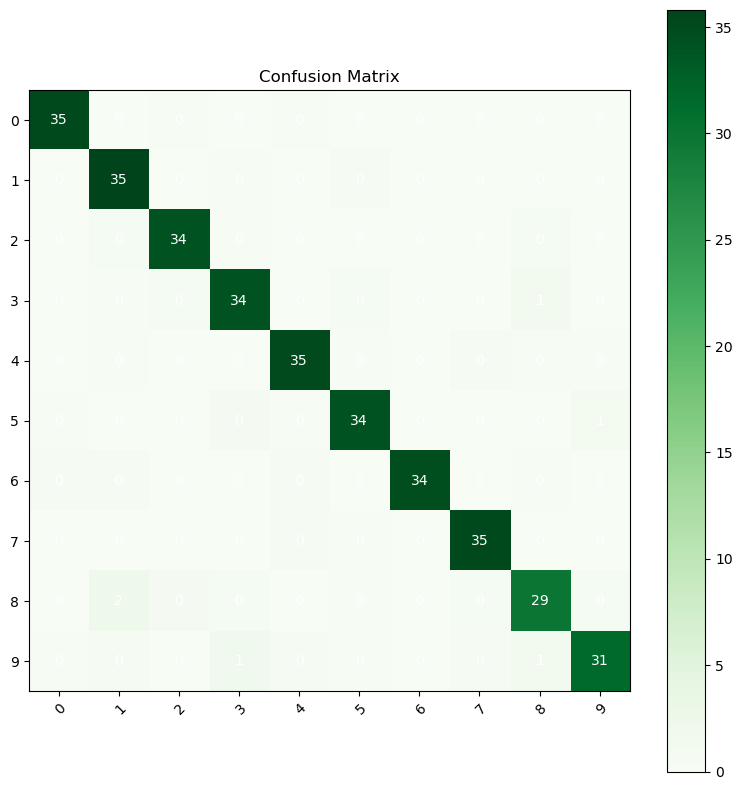

In [39]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(average_confusion_matrix, cmap='Greens')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, int(average_confusion_matrix[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.show()


Results: the overall performance seems to be fine since the diagonal elements of the confusion matrix represent the correct predictions of each class and the off-diagonal elements represent the misclassifications for each class.


# One-against-the-rest classification with RegressionForest

In [14]:
# Train ten one-against-the-rest regression forests for the 10 digits.
# Make sure that all training sets are balanced between the current digit and the rest.
# Assign test instances to the digit with highest score, 
# or to "unknown" if all scores are negative.
# Compute and plot the confusion matrix after 5-fold cross-validation and comment on your results.
... # your code here

Ellipsis

<div style="color: green; font-weight:
insert comments as Markdown cells starting with
bold">Comment</div>

In [86]:
def bootstrap_sampling(features, responses):
    '''return a bootstrap sample of features and responses
    '''

    class1_idx = np.where(responses == 1)[0]
    class_rest_idx = np.where(responses != 1)[0]
    class_rest_idx = np.random.choice(class_rest_idx, np.sum(responses == -1), replace=False)
    indices_balanced = np.concatenate([class1_idx, class_rest_idx])

    # Class balancing
    indices = np.random.choice(indices_balanced, indices_balanced.shape[0], replace=True)
    bootstrap_features = features[indices]
    bootstrap_responses = responses[indices] # your code here
    return bootstrap_features,bootstrap_responses
    #raise NotImplementedError("bootstrap_sampling(): remove this exception after adding your code above.")

Mean Error Rate with Cross Validation: 0.918745 +/- 0.016478


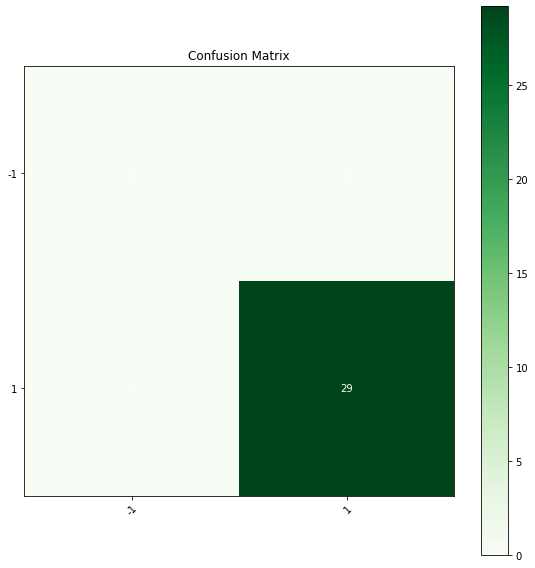

Mean Error Rate with Cross Validation: 0.930994 +/- 0.007157


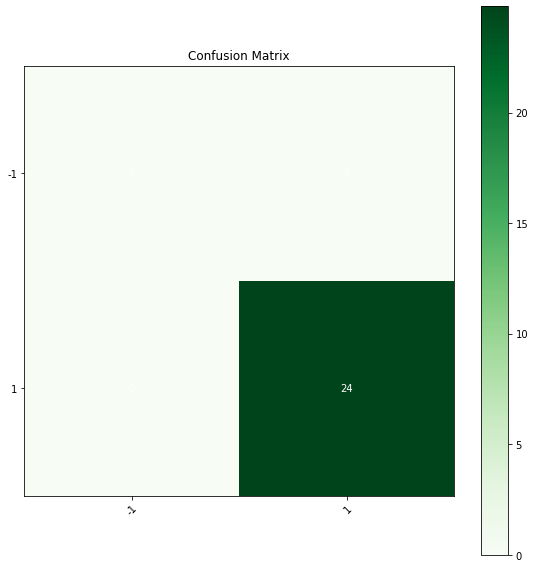

Mean Error Rate with Cross Validation: 0.938793 +/- 0.006987


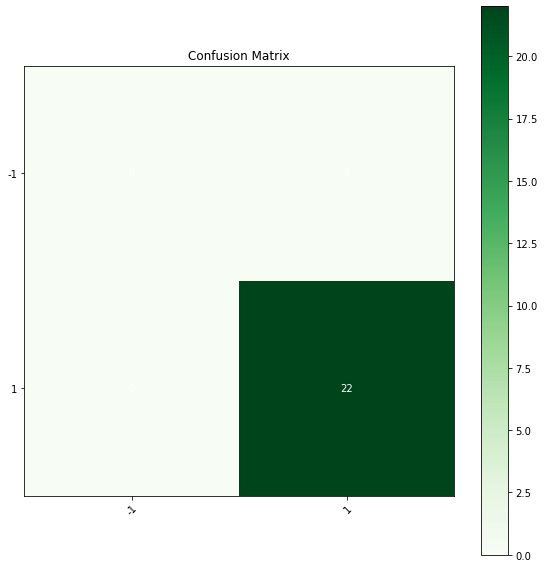

Mean Error Rate with Cross Validation: 0.945461 +/- 0.006029


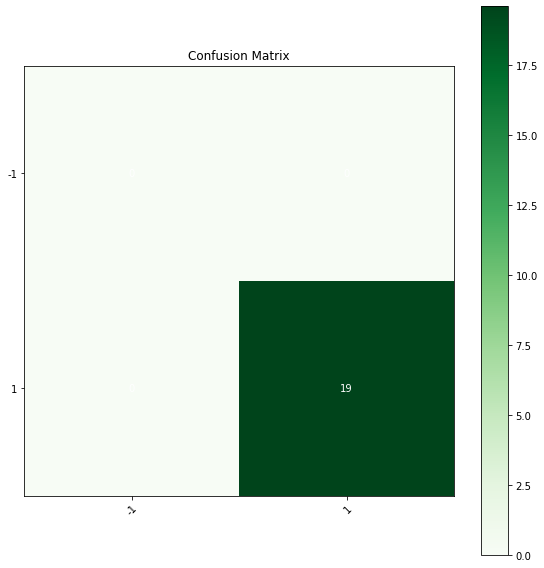

Mean Error Rate with Cross Validation: 0.930995 +/- 0.004806


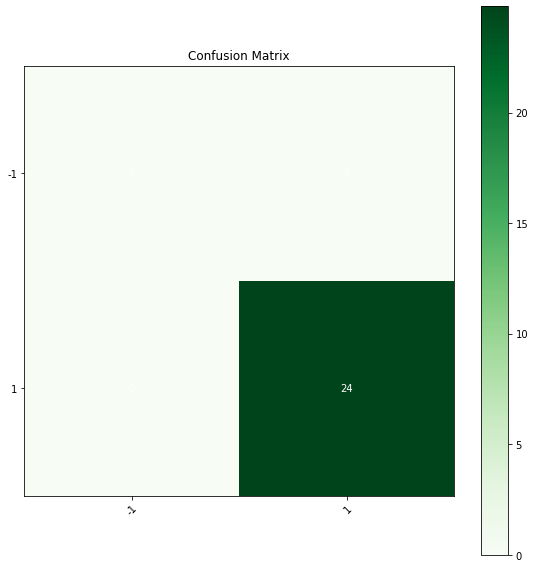

Mean Error Rate with Cross Validation: 0.941007 +/- 0.008733


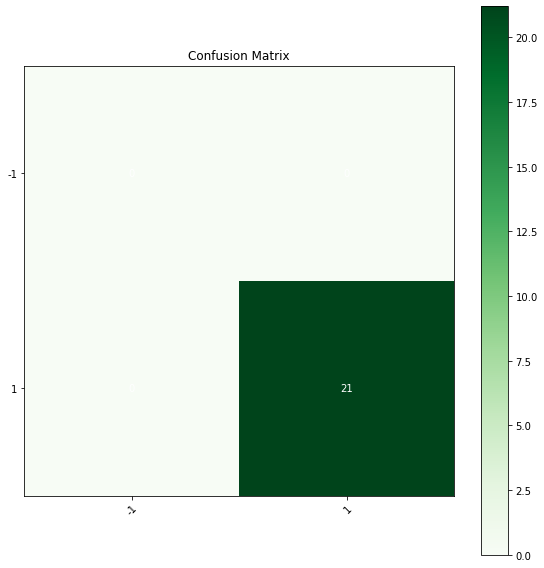

Mean Error Rate with Cross Validation: 0.919865 +/- 0.010781


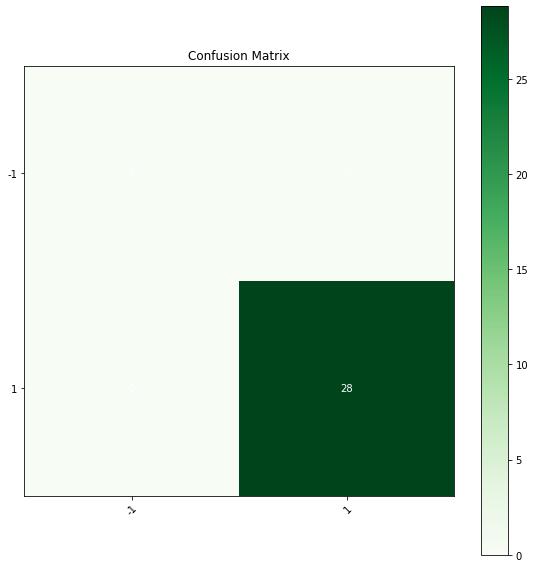

Mean Error Rate with Cross Validation: 0.927084 +/- 0.014311


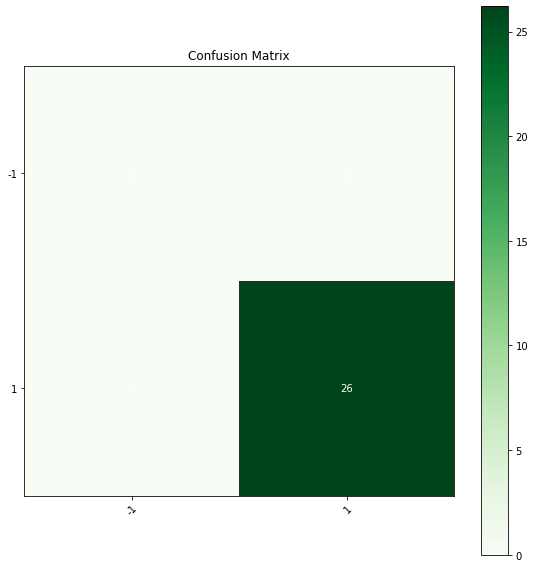

Mean Error Rate with Cross Validation: 0.969943 +/- 0.009229


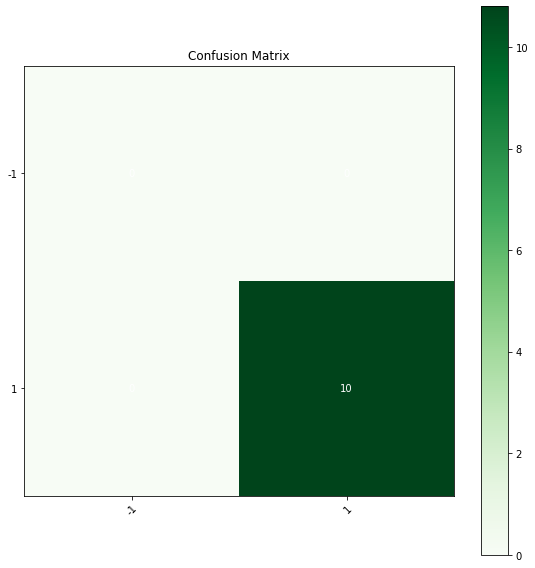

0


In [98]:
from sklearn.metrics import confusion_matrix
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

def one_v_rest(features, targets):
    # Sorry no time to implement as a proper function

    classifiers = []
    mean_error_rates = []

    features = digits.data

    for digit in range(max(digits.target)):

        responses = np.array([1 if l == digit else -1 for l in digits.target])

        assert(features.shape[0] == responses.shape[0])

        k=5

        # CV
        k_folds = KFold(n_splits=k, shuffle=True)
        mean_rate = np.zeros(k)
        confusion_matrix_total = np.zeros((2,2))

        for i, (train, test) in enumerate(k_folds.split(features)):

            x_train, x_test = features[train], features[test]


            # train
            RF = RegressionForest(n_trees=10, n_min=10)
            RF.train(x_train, responses[train])

            # test
            predicted_labels = []

            for idx in range(x_test.shape[0]):
                predicted_labels.append(RF.predict(x_test[idx, :]))

            predicted_labels = np.array(predicted_labels)
            predicted_labels = np.where(predicted_labels >= 0.5, 1, 0)

            mean_rate[i] = np.mean(predicted_labels != responses[test])


            confusion_matrix_total += confusion_matrix(responses[test], predicted_labels, labels=np.unique(responses))

        average_confusion_matrix = confusion_matrix_total / k

        print("Mean Error Rate with Cross Validation: %f +/- %f"%(np.mean(mean_rate), np.std(mean_rate)))
        mean_error_rates.append(np.mean(mean_rate))



        fig, ax = plt.subplots(figsize=(8, 8))
        im = ax.imshow(average_confusion_matrix, cmap='Greens')

        # Add colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set tick labels
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels([-1, 1])
        ax.set_yticklabels([-1, 1])

        # Rotate the tick labels and set their alignment
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations
        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, int(average_confusion_matrix[i, j]),
                               ha="center", va="center", color="w")

        ax.set_title("Confusion Matrix")
        fig.tight_layout()
        plt.show()



    if all(np.array(mean_error_rates) >= 0):
        return mean_error_rates.index(min(mean_error_rates))

    else:
        retrun "Unkown"


Apparently, in our case, 1 against rest multi-class classification was not a good choice yielding poor predictive performance.